# Facial Expression Recognition
---
Facial Expression Recognition (FER) is a branch of computer vision and artificial intelligence that focuses on analyzing human facial expressions to infer emotions, intentions, or reactions. It has gained significant attention due to its wide range of applications in fields such as human-computer interaction, mental health assessment, marketing, surveillance, and entertainment.

Facial expressions are one of the most natural and universal ways humans communicate emotions. They are crucial in interpreting the underlying emotional state of an individual. FER systems leverage machine learning and deep learning techniques to automatically identify these expressions from images or video data.

**Key Objectives of this Notebook**

1. Understanding the Basics: Explore the fundamentals of facial expression recognition and its importance.
2. Data Exploration: Work with a dataset of labeled facial expressions to understand the challenges and opportunities.
3. Preprocessing: Learn techniques for preparing image data for analysis, including face detection, resizing, and normalization.
4. Modeling: Build and evaluate machine learning or deep learning models (e.g., Convolutional Neural Networks) for FER.
5. Performance Evaluation: Use metrics like accuracy to  assess the effectiveness of the model.
6. Application Insights: Discuss potential use cases and the ethical considerations involved in implementing FER systems.


# Importing Libraries
<!-- ### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html) -->


In [28]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets, models, datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import kagglehub

from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import zipfile
import shutil
import random
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import timm
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from collections import defaultdict
import matplotlib.pyplot as plt
import copy

---
# Input Variables
---

User-Defined Vairables: This section outlines the key input variables that can be customized to suit the requirements of the task or experiment. These variables allow flexibility in configuring the system or model and adapting it to different datasets, objectives, and scenarios.

In [2]:
# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Data transform for grayscale images
# Augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize to 48x48
    # transforms.Grayscale(),  # Convert to grayscale (1 channel)
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),  # Randomly rotate by ±10 degrees
    transforms.ToTensor(),  # Convert image to PyTorch tensor (C x H x W)
    # transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale: single mean and std
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Ensure test images are resized correctly
    # transforms.Grayscale(),  # Convert to grayscale (1 channel)
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading [Data](https://pytorch.org/vision/stable/datasets.html)
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

### **Dataset Description:**

**1. FER2013 Dataset**  
- **Source:** [Kaggle: FER2013](https://www.kaggle.com/datasets/msambare/fer2013)  
- **Content:**  
  - 35,887 grayscale, 48x48 pixel face images  
  - Each image is categorized into one of seven emotions: *Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise*  
- **Usage:** Widely used for facial expression recognition and affective computing research

---

**2. AffectNet Training Data**  
- **Source:** [Kaggle: AffectNet Training Data](https://www.kaggle.com/datasets/noamsegal/affectnet-training-data)  
- **Content:**  
  - Large dataset of facial images annotated with emotion categories and valence-arousal values  
  - Categories include *Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt*  
- **Usage:** Used to train models on both categorical and dimensional emotion recognition tasks

---

**3. MMA Facial Expression Dataset**  
- **Source:** [Kaggle: MMA Facial Expression](https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression)  
- **Content:**  
  - Real-world images from MMA fighters captured mid-action  
  - Emotion classes such as *Angry, Happy, Neutral*  
- **Usage:** Ideal for testing robust facial expression recognition in non-laboratory, dynamic conditions



In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
# path2 = kagglehub.dataset_download("mahmoudima/mma-facial-expression")
# path3 = kagglehub.dataset_download("noamsegal/affectnet-training-data")
# path4 = kagglehub.dataset_download("priyeshsingh57/facial-expression-combined-dataset-team-60")

print("Path to dataset files:", path)
# print("Path to dataset files:", path2)
# print("Path to dataset files:", path3)
# print("Path to dataset files:", path4)


train_data = datasets.ImageFolder(root=path+'/train',transform=train_transform)
test_data = datasets.ImageFolder(root=path+'/test',transform=test_transform)
# train_data2 = datasets.ImageFolder(root=path2+'/MMAFEDB/train',transform=train_transform)
# test_data2 = datasets.ImageFolder(root=path2+'/MMAFEDB/test',transform=test_transform)
# valid_data2 = datasets.ImageFolder(root=path2+'/MMAFEDB/valid',transform=test_transform)
# train_data3 = datasets.ImageFolder(root=path3,transform=train_transform)

# test_data3 = datasets.ImageFolder(root=path3+'/test',transform=test_transform)

Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


# Data Preparation

In [7]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
# define samplers for obtaining training and validation batches
# Samples elements randomly from a given list of indices, without replacement.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoaders and Batching

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# Visualization

In [10]:
# specify the image classes
classes = train_data.classes
num_classes = len(classes)
print(num_classes)
print(classes)

7
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Visualize a Batch of Training Data

In [11]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 32x32)

(20, 3, 48, 48)

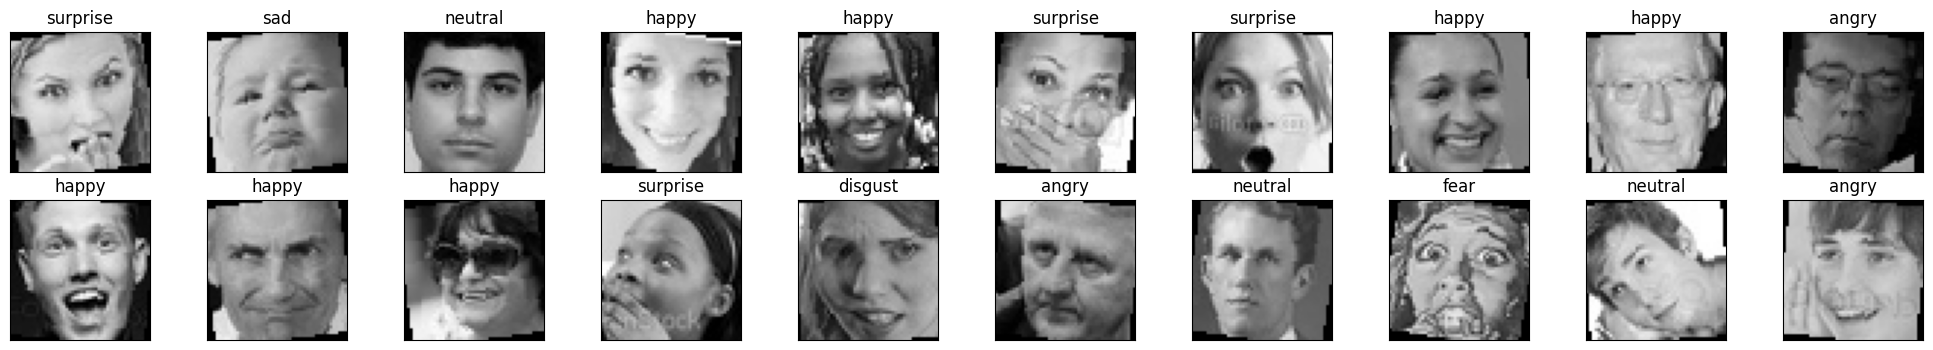

In [13]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

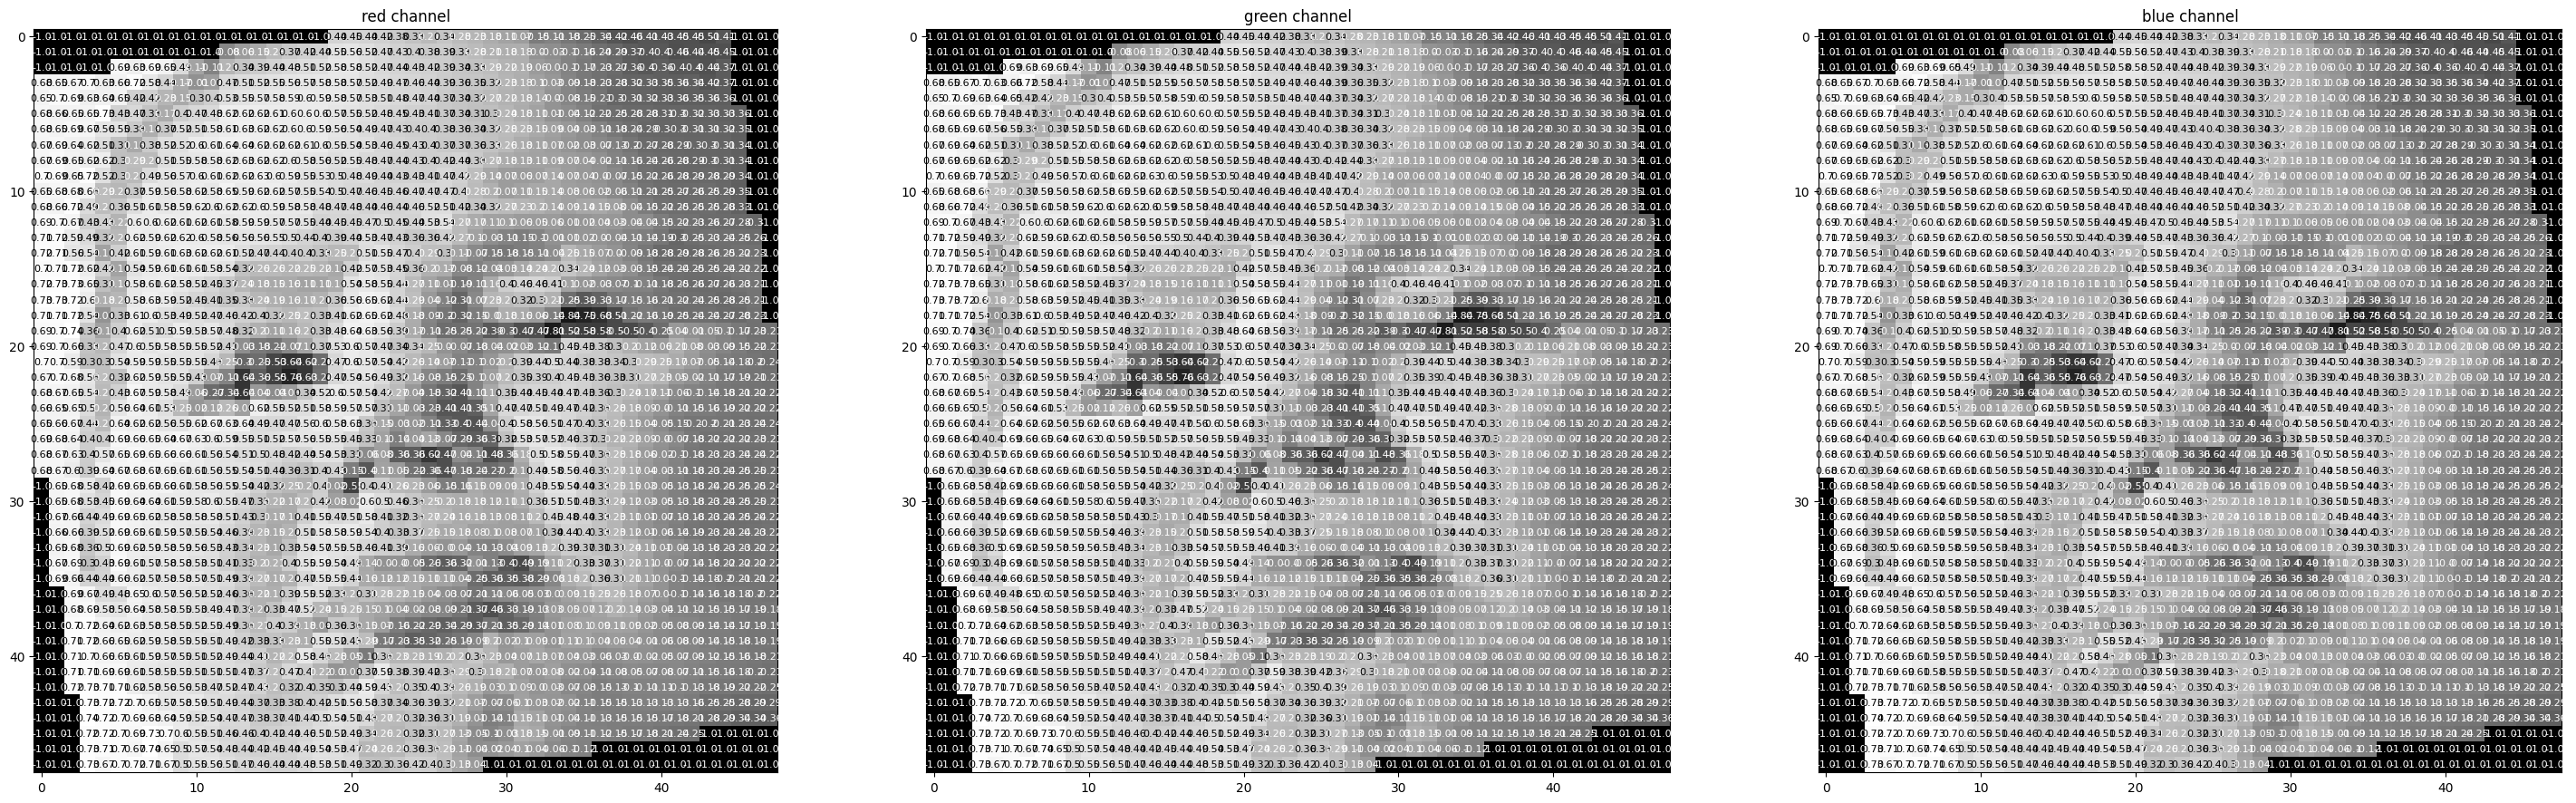

In [14]:
rgb_img = np.squeeze(images[1])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [15]:
def analyze_image(image_path):
    # Load the image using Pillow
    img_pillow = Image.open(image_path)
    print("Using Pillow:")
    print(f"Mode: {img_pillow.mode}")  # "L" for grayscale, "RGB" for color
    print(f"Size: {img_pillow.size}")  # (width, height)
    print(f"Format: {img_pillow.format}")  # File format (e.g., JPEG, PNG)

    # Check if the image is grayscale
    is_grayscale_pillow = img_pillow.mode == "L"
    print(f"Is Grayscale: {is_grayscale_pillow}")

    # Load the image using OpenCV
    img_cv = cv2.imread(image_path)
    print("\nUsing OpenCV:")
    print(f"Shape: {img_cv.shape}")  # (height, width, channels) or (height, width) for grayscale
    print(f"Data Type: {img_cv.dtype}")  # Data type of pixel values (e.g., uint8)

    # Check if the image is grayscale in OpenCV
    is_grayscale_cv = len(img_cv.shape) == 2
    print(f"Is Grayscale: {is_grayscale_cv}")

    # Check pixel range
    min_pixel = np.min(img_cv)
    max_pixel = np.max(img_cv)
    print(f"Pixel Range: {min_pixel} to {max_pixel}")

    # Display an image summary
    if is_grayscale_pillow:
        print("\nThis is a grayscale image.")
    elif img_pillow.mode == "RGB":
        print("\nThis is a color image (RGB).")
    else:
        print("\nThis image has a different mode (e.g., CMYK).")

# Example usage
# image_path = "/content/Training_1206.jpg"  # Replace with your image file
# analyze_image(image_path)



---
# Functions for Training, Testing and Visualization

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

**Warning**: The training process can take about 30 mins!

In [16]:
# @title Training Function
def train_and_validate_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=5, train_on_gpu=False, save_path='model_facial.pth'):
    """
    Train and validate the model.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training set.
        valid_loader (DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        n_epochs (int): Number of epochs to train the model.
        train_on_gpu (bool): Whether to train on GPU.
        save_path (str): File path to save the model.

    Returns:
        model (torch.nn.Module): The trained model.
    """
    if train_on_gpu:
      model.cuda()

    valid_loss_min = np.Inf  # Track change in validation loss
    train_errors = []
    valid_errors = []

    for epoch in range(1, n_epochs + 1):
        # Initialize loss trackers
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # Train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # Move tensors to GPU if available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Compute loss
            loss = criterion(output, target)
            # Backward pass
            loss.backward()
            # Optimization step
            optimizer.step()
            # Update training loss
            train_loss += loss.item() * data.size(0)

        ######################
        # Validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                # Move tensors to GPU if available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)
                # Compute loss
                loss = criterion(output, target)
                # Update validation loss
                valid_loss += loss.item() * data.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        train_errors.append(train_loss)
        valid_errors.append(valid_loss)

        # Print training/validation statistics
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model, train_errors, valid_errors


In [17]:
# @title Testing_Function
def evaluate_model(model, test_loader, criterion, num_classes, classes, test_on_gpu=False):
    """
    Evaluate the model on the test dataset and calculate accuracy for each class and overall.

    Parameters:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test set.
        criterion (torch.nn.Module): Loss function.
        num_classes (int): Number of classes in the dataset.
        classes (list): List of class names corresponding to the labels.
        test_on_gpu (bool): Whether to perform evaluation on GPU.

    Returns:
        dict: Contains overall accuracy, per-class accuracy, test loss, and predictions.
    """
    if train_on_gpu:
      model.cuda()

    test_loss = 0.0
    class_correct = list(0. for _ in range(num_classes))
    class_total = list(0. for _ in range(num_classes))

    size = len(test_loader.dataset)
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size, num_classes))

    idx = 0
    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            # Move tensors to GPU if available
            if test_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update test loss
            test_loss += loss.item() * data.size(0)

            # Convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # Compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not test_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

            # Store predictions, true labels, and probabilities
            predictions[idx:idx + len(target)] = pred.to('cpu').numpy()
            all_classes[idx:idx + len(target)] = target.to('cpu').numpy()
            all_proba[idx:idx + len(target), :] = output.to('cpu').detach().numpy()
            idx += len(target)

            # Calculate test accuracy for each class
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # Average test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    # Print accuracy for each class
    class_accuracies = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
            class_accuracies[classes[i]] = accuracy
        else:
            print('Test Accuracy of %5s: N/A (no test examples)' % (classes[i]))
            class_accuracies[classes[i]] = None

    # Overall accuracy
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        overall_accuracy, np.sum(class_correct), np.sum(class_total)))

    return {
        "test_loss": test_loss,
        "overall_accuracy": overall_accuracy,
        "class_accuracies": class_accuracies,
        "predictions": predictions,
        "true_labels": all_classes,
        "probabilities": all_proba
    }




In [18]:
# @title Error Plot Function
#TODO: Write code to plot the training and vadliation errors (MER) over epochs
import matplotlib.pyplot as plt
def plot_errors(train_errors, valid_errors):
    epochs = range(1, len(train_errors) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_errors, label='Training MER')
    plt.plot(epochs, valid_errors, label='Validation MER')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and Validation Errors')
    plt.legend()
    plt.grid(True)
    plt.show()


In [19]:
# @title Confusion Matrix
def make_fig_cm(cm):
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(num_classes);
    plt.xticks(tick_marks, classes, rotation=90);
    plt.yticks(tick_marks, classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [20]:
# @title Visualize Sample Test Results
def visualize_predictions(model, test_loader, classes, train_on_gpu=False, batch_size=20):
    """
    Visualize predictions from the model on a batch of test images.

    Parameters:
        model (torch.nn.Module): The trained model for prediction.
        test_loader (DataLoader): DataLoader for the test set.
        classes (list): List of class names corresponding to the labels.
        train_on_gpu (bool): Whether the model and data are on GPU.
        batch_size (int): Number of images to visualize from the batch.

    Returns:
        None
    """
    # Obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images_numpy = images.numpy()

    # Move inputs to GPU if available
    if train_on_gpu:
        images = images.cuda()

    # Get sample outputs
    output = model(images)
    # Convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(min(batch_size, len(images))):
        ax = fig.add_subplot(2, batch_size // 2, idx + 1, xticks=[], yticks=[])
        imshow(images[idx] if not train_on_gpu else images[idx].cpu())
        ax.set_title(
            "{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
            color=("green" if preds[idx] == labels[idx].item() else "red")
        )
    plt.show()


# Baseline Model

### Baseline Model: CNN Architecture Description

Our baseline model is a Convolutional Neural Network (CNN) designed for image classification tasks. The architecture is simple yet effective for learning key features in the dataset. Below are the key components and operations:

1. **Convolutional Layers**:
   - Three convolutional layers are included:
     - `conv1`: Processes input images (e.g., \(32 \times 32 \times 3\)) with 16 filters of size \(3 \times 3\), maintaining spatial dimensions with padding.
     - `conv2`: Expands feature maps to 32 channels.
     - `conv3`: Further increases feature maps to 64 channels.

2. **Pooling Layers**:
   - Each convolutional layer is followed by a **Max Pooling** layer (\(2 \times 2\)) to downsample feature maps, reducing spatial dimensions by half after each pooling.

3. **Fully Connected Layers**:
   - After the convolutional layers, feature maps are flattened to a vector (\(64 \times 6 \times 6\)) for input to fully connected layers:
     - `fc1`: Maps the flattened vector to 500 hidden units with **ReLU** activation.
     - `fc2`: Outputs the final predictions across the number of classes in the dataset (`num_classes`).

4. **Regularization**:
   - Dropout layers with a probability of 0.25 are applied after flattening and the first fully connected layer to prevent overfitting.

5. **Activation and Flow**:
   - **ReLU activation** is applied after each convolutional and fully connected layer to introduce non-linearity.
   - The model outputs class scores after the second fully connected layer.

This architecture forms the baseline for our experiments, offering simplicity while maintaining sufficient complexity to extract meaningful features. It serves as a benchmark against which more advanced models (e.g., Vision Transformers) can be compared.


In [21]:
# @title Defining Model
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        # self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc1 = nn.Linear(64 * 6 * 6, 500) # NEW CODE
        # linear layer (500 -> 10)
        # self.fc2 = nn.Linear(500, 10)
        self.fc2 = nn.Linear(500, num_classes) # NEW CODE
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        # x = x.view(-1, 64 * 4 * 4)
        x = x.view(-1, 64 * 6 * 6) # NEW CODE
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

Epoch: 1 	Training Loss: 1.731913 	Validation Loss: 1.632384
Validation loss decreased (inf --> 1.632384). Saving model ...
Epoch: 2 	Training Loss: 1.593908 	Validation Loss: 1.542442
Validation loss decreased (1.632384 --> 1.542442). Saving model ...
Epoch: 3 	Training Loss: 1.527645 	Validation Loss: 1.478868
Validation loss decreased (1.542442 --> 1.478868). Saving model ...
Epoch: 4 	Training Loss: 1.470760 	Validation Loss: 1.432582
Validation loss decreased (1.478868 --> 1.432582). Saving model ...
Epoch: 5 	Training Loss: 1.432438 	Validation Loss: 1.389096
Validation loss decreased (1.432582 --> 1.389096). Saving model ...
Epoch: 6 	Training Loss: 1.397266 	Validation Loss: 1.367712
Validation loss decreased (1.389096 --> 1.367712). Saving model ...
Epoch: 7 	Training Loss: 1.365631 	Validation Loss: 1.343983
Validation loss decreased (1.367712 --> 1.343983). Saving model ...
Epoch: 8 	Training Loss: 1.344383 	Validation Loss: 1.320791
Validation loss decreased (1.343983 --> 1

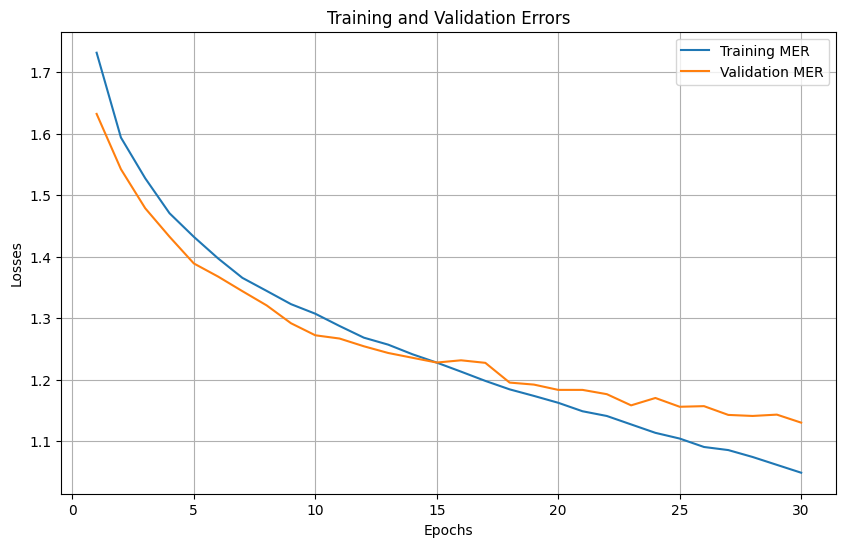

In [22]:
# @title Training Model
model = Net()
n_epochs = 30
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Define parameters and call the function
trained_model, train_errors, valid_errors  = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    train_on_gpu=torch.cuda.is_available(),
    save_path='best_model.pth'
)
plot_errors(train_errors, valid_errors)


Test Loss: 1.122155

Test Accuracy of angry: 39% (379/958)
Test Accuracy of disgust: 35% (39/111)
Test Accuracy of  fear: 33% (346/1024)
Test Accuracy of happy: 81% (1444/1774)
Test Accuracy of neutral: 63% (781/1233)
Test Accuracy of   sad: 44% (558/1247)
Test Accuracy of surprise: 73% (612/831)

Test Accuracy (Overall): 57% (4159/7178)


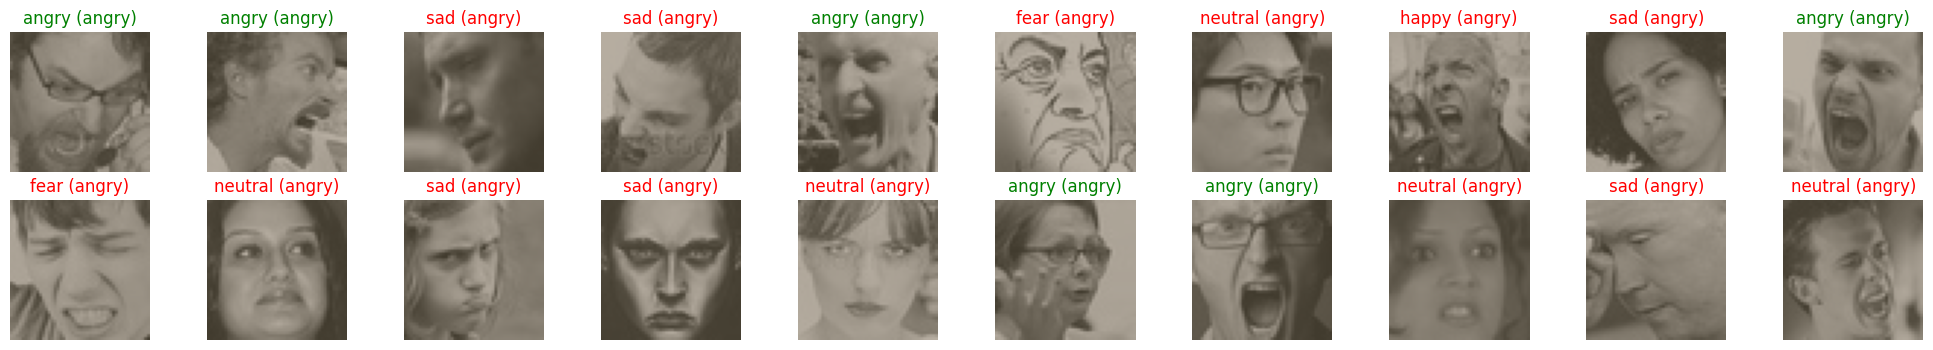

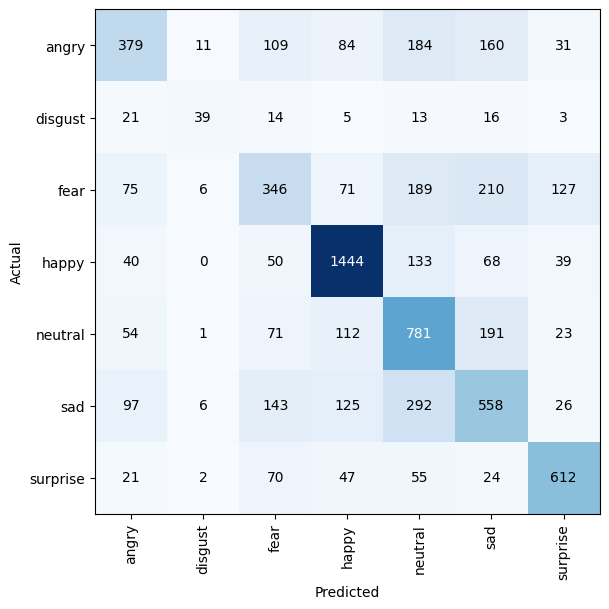

In [25]:
# @title Testing

# Evaluate the model
# state_dict = torch.load('/content/best_model.pth', map_location='cpu', weights_only=True)
# model = None
state_dict = torch.load('/content/drive/MyDrive/03_Duke_University/29_Term_3_Modern_Analytics/Final_Project/Models/model_facial_netCNN_LossCEL_OptimAdam_LR0001_decay1e-6_epoch30_Rperc57.pth', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    num_classes=7,
    classes=classes,
    test_on_gpu=torch.cuda.is_available()
)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    classes=classes,
    train_on_gpu=torch.cuda.is_available(),
    batch_size=20
)

all_classes = results['true_labels']
predictions = results['predictions']
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)


# Other Models for Training and Testing

## Resnet50 Model

### ResNet-50 Model Description

The ResNet-50 model is a state-of-the-art deep learning architecture designed for image classification tasks. Below are the key details of the model used in our setup:

1. **Pretrained ResNet-50 Backbone**:
   - The model is initialized using a pretrained ResNet-50 architecture, leveraging pre-trained weights from ImageNet. This allows the model to take advantage of robust feature representations learned from a large-scale dataset.

2. **Modified Fully Connected Layer**:
   - The original fully connected (fc) layer is replaced to adapt the model to the specific classification task:
     - Input features: 2048 (from the ResNet-50 architecture).
     - Output features: 7 (number of classes in our dataset).
     - Includes a `Softmax` activation function to output class probabilities.

3. **Freezing and Fine-Tuning**:
   - All layers are set to `requires_grad=True`, allowing the model to update the weights of the pretrained layers during training. This ensures the model fine-tunes the entire network for our specific task.
   - Special attention is given to the fully connected layer (`fc`) to ensure its weights are trainable and optimized for the classification problem.

4. **Parameters for Optimization**:
   - Parameters requiring gradient updates are collected into a list (`params_to_update`) for efficient optimization during training.

5. **Usage**:
   - The ResNet-50 model serves as a robust feature extractor, augmented with a task-specific fully connected layer for precise classification. Its pre-trained backbone significantly reduces training time while improving model performance on the given dataset.

This architecture combines the power of transfer learning with task-specific adjustments, making it highly effective for our image classification problem.


In [70]:
# @title Defining Model
# instantiate Resnet50 model
model_resnet50 = models.resnet50(pretrained=True)

# replace the last fully connected layer to suit the classification problem
model_resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features  = 2048,
        out_features = 7
    ),
    torch.nn.Softmax(dim=1)
)

# freeze / unfreeze all layers by toggling the below
# setting to True because we want to use pre-trained weights
for param in model_resnet50.parameters():
    param.requires_grad = True

# freeze / unfreeze just the fully connected layer
for name, param in model_resnet50.named_parameters():
    if name.startswith('fc'):
        param.requires_grad = True

params_to_update = []

for param in model_resnet50.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

model = model_resnet50
# view the model structure
# print(model_resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 1.832903 	Validation Loss: 1.793900
Validation loss decreased (inf --> 1.793900). Saving model ...
Epoch: 2 	Training Loss: 1.768178 	Validation Loss: 1.844038
Epoch: 3 	Training Loss: 1.750003 	Validation Loss: 1.724689
Validation loss decreased (1.793900 --> 1.724689). Saving model ...
Epoch: 4 	Training Loss: 1.719608 	Validation Loss: 1.714702
Validation loss decreased (1.724689 --> 1.714702). Saving model ...
Epoch: 5 	Training Loss: 1.714847 	Validation Loss: 1.711698
Validation loss decreased (1.714702 --> 1.711698). Saving model ...
Epoch: 6 	Training Loss: 1.700726 	Validation Loss: 1.701486
Validation loss decreased (1.711698 --> 1.701486). Saving model ...
Epoch: 7 	Training Loss: 1.690487 	Validation Loss: 1.692154
Validation loss decreased (1.701486 --> 1.692154). Saving model ...
Epoch: 8 	Training Loss: 1.681952 	Validation Loss: 1.673249
Validation loss decreased (1.692154 --> 1.673249). Saving model ...
Epoch: 9 	Training Loss: 1.671209 	Valida

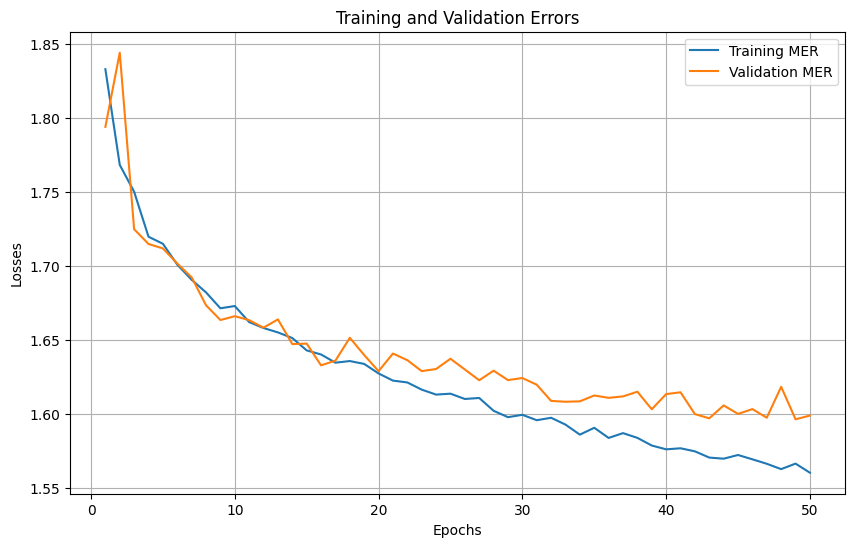

In [71]:
# @title Training Model
model = model_resnet50
n_epochs = 50
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

# Define parameters and call the function
trained_model, train_errors, valid_errors  = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    train_on_gpu=torch.cuda.is_available(),
    save_path='model_facial_resnet50_LossCEL_OptimAdam_LR001_decay1e-6_epoch50.pth'
)
plot_errors(train_errors, valid_errors)


Test Loss: 1.592640

Test Accuracy of angry: 51% (491/958)
Test Accuracy of disgust:  0% ( 0/111)
Test Accuracy of  fear: 25% (264/1024)
Test Accuracy of happy: 84% (1496/1774)
Test Accuracy of neutral: 58% (719/1233)
Test Accuracy of   sad: 42% (534/1247)
Test Accuracy of surprise: 69% (578/831)

Test Accuracy (Overall): 56% (4082/7178)


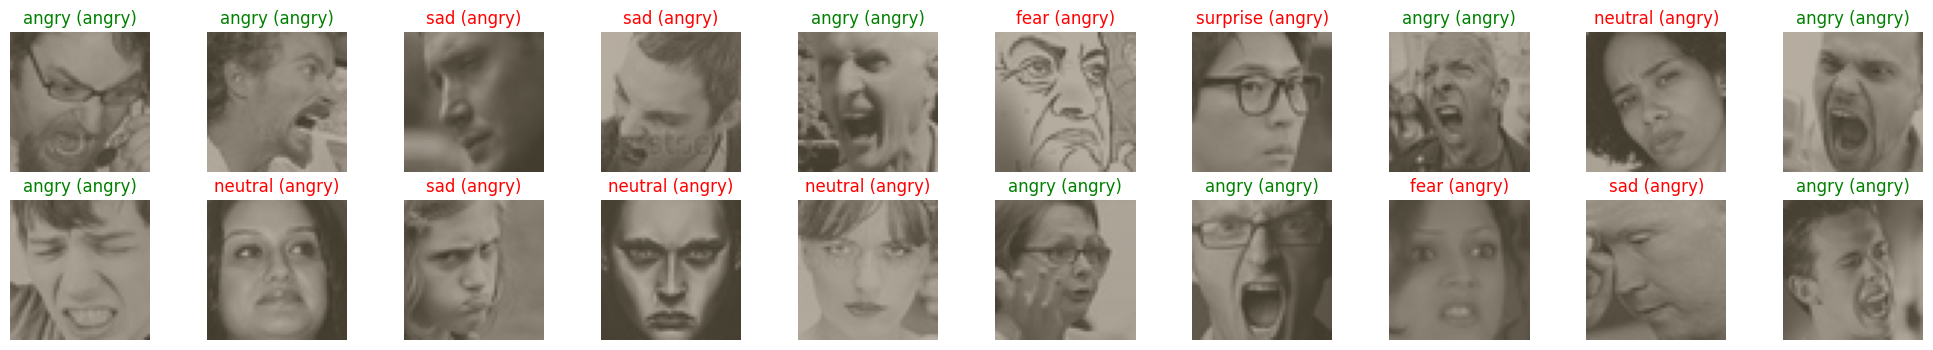

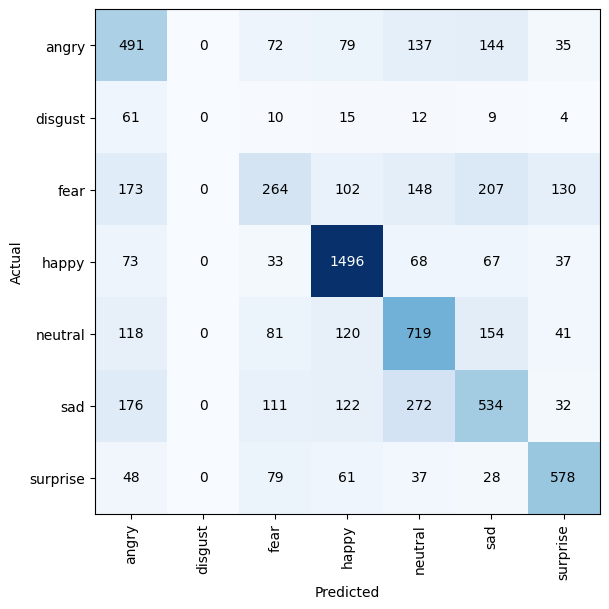

In [72]:
# @title Testing

# Evaluate the model
# state_dict = torch.load('/content/best_model.pth', map_location='cpu', weights_only=True)
# model = None
state_dict = torch.load('/content/model_facial_resnet50_LossCEL_OptimAdam_LR001_decay1e-6_epoch50.pth', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    num_classes=7,
    classes=classes,
    test_on_gpu=torch.cuda.is_available()
)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    classes=classes,
    train_on_gpu=torch.cuda.is_available(),
    batch_size=20
)

all_classes = results['true_labels']
predictions = results['predictions']
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)


## EmotionCNN_1 Model

### EmotionCNN Model Description

The **EmotionCNN** model is a custom convolutional neural network (CNN) designed for emotion classification. Below are the key components of the architecture:

1. **Convolutional Blocks**:
   - **First Block**:
     - Two convolutional layers (`conv1` and `conv2`) with 32 and 64 filters respectively, followed by batch normalization, max pooling, and dropout (25%).
   - **Second Block**:
     - Two convolutional layers (`conv3` and `conv4`) with 128 and 256 filters respectively, followed by batch normalization, max pooling, and dropout (25%).

2. **Fully Connected Layers**:
   - The flattened feature map from the second block is fed into:
     - `fc1`: Fully connected layer with 1024 units and ReLU activation.
     - `fc2`: Final layer with 7 units corresponding to the number of emotion classes.
   - Dropout (50%) is applied before the output layer to prevent overfitting.

3. **Input and Output**:
   - Input: RGB images (48x48x3 dimensions).
   - Output: Class scores for 7 emotion categories (softmax applied during evaluation).

This model is compact yet effective, leveraging batch normalization and dropout for regularization, and is well-suited for emotion recognition tasks on moderately sized datasets.


In [60]:
# @title Defining Model
class EmotionCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=7):
        super(EmotionCNN, self).__init__()

        # Step 1: First Convolutional Block
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Step 2: Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Step 3: Fully Connected Layers
        self.flatten_size = 256 * 12 * 12  # Adjusted for input size of 48x48x3
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        # Step 1: First Convolutional Block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Step 2: Second Convolutional Block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Step 3: Flatten the Output
        x = x.view(-1, self.flatten_size)  # Flatten the feature map

        # Step 4: Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)  # No activation here; use softmax during evaluation if needed

        return x

# Initialize the model
input_channels = 3  # For RGB images (3 channels)
num_classes = 7
model_emotioncnn = EmotionCNN(input_channels=input_channels, num_classes=num_classes)

Epoch: 1 	Training Loss: 1.704352 	Validation Loss: 1.582723
Validation loss decreased (inf --> 1.582723). Saving model ...
Epoch: 2 	Training Loss: 1.570451 	Validation Loss: 1.477569
Validation loss decreased (1.582723 --> 1.477569). Saving model ...
Epoch: 3 	Training Loss: 1.486528 	Validation Loss: 1.338148
Validation loss decreased (1.477569 --> 1.338148). Saving model ...
Epoch: 4 	Training Loss: 1.394018 	Validation Loss: 1.293349
Validation loss decreased (1.338148 --> 1.293349). Saving model ...
Epoch: 5 	Training Loss: 1.337216 	Validation Loss: 1.276407
Validation loss decreased (1.293349 --> 1.276407). Saving model ...
Epoch: 6 	Training Loss: 1.297884 	Validation Loss: 1.257711
Validation loss decreased (1.276407 --> 1.257711). Saving model ...
Epoch: 7 	Training Loss: 1.243261 	Validation Loss: 1.216848
Validation loss decreased (1.257711 --> 1.216848). Saving model ...
Epoch: 8 	Training Loss: 1.198870 	Validation Loss: 1.194336
Validation loss decreased (1.216848 --> 1

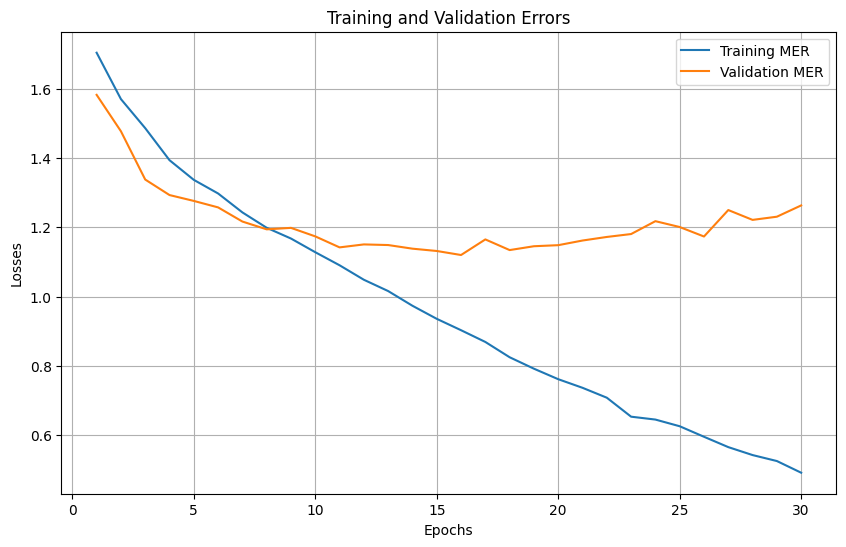

In [62]:
# @title Training Model
model = model_emotioncnn
n_epochs = 30
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Define parameters and call the function
trained_model, train_errors, valid_errors  = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    train_on_gpu=torch.cuda.is_available(),
    save_path='model_facial_model_emotioncnn_LossCEL_OptimSGD_LR01_epoch30.pth'
)
plot_errors(train_errors, valid_errors)


Test Loss: 1.115870

Test Accuracy of angry: 45% (433/958)
Test Accuracy of disgust: 45% (50/111)
Test Accuracy of  fear: 34% (351/1024)
Test Accuracy of happy: 85% (1509/1774)
Test Accuracy of neutral: 66% (815/1233)
Test Accuracy of   sad: 38% (479/1247)
Test Accuracy of surprise: 74% (617/831)

Test Accuracy (Overall): 59% (4254/7178)


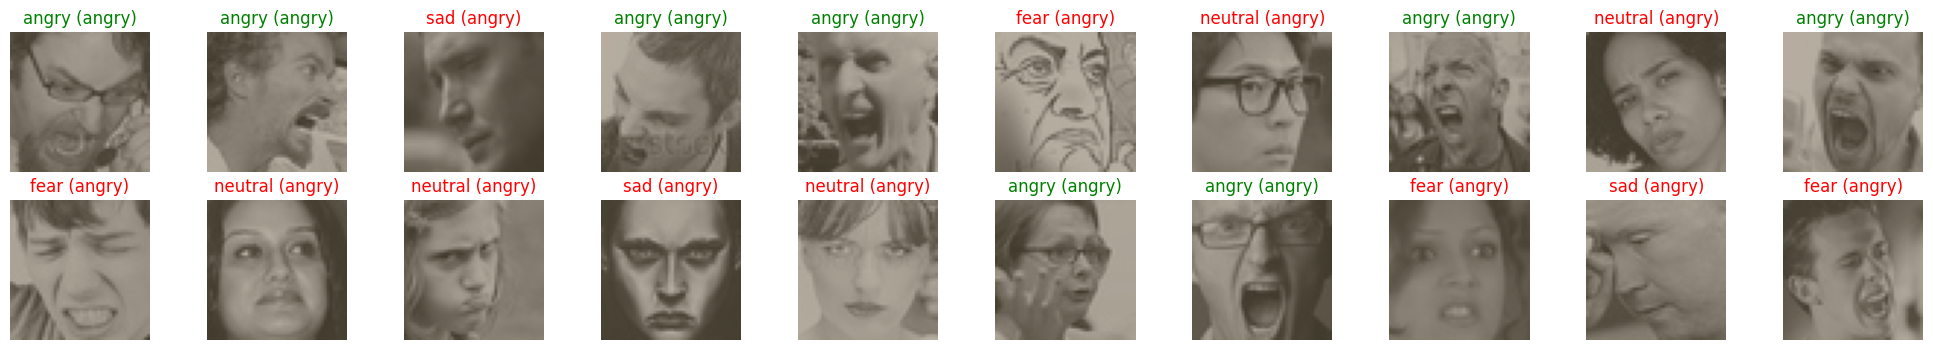

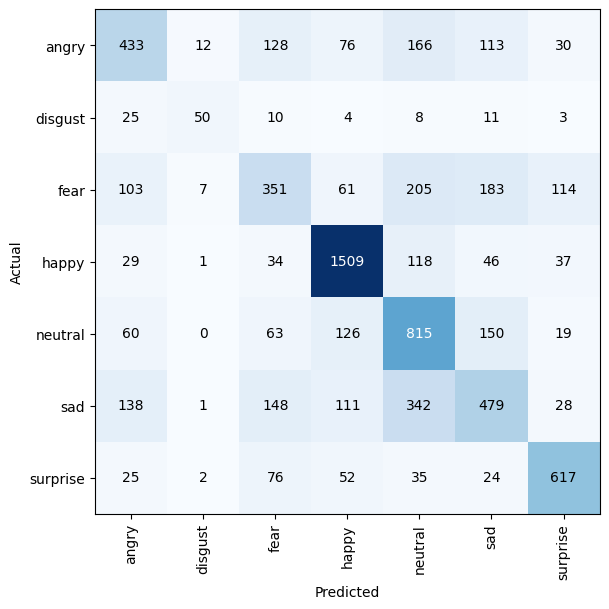

In [63]:
# @title Testing

# Evaluate the model
state_dict = torch.load('/content/model_facial_model_emotioncnn_LossCEL_OptimSGD_LR01_epoch30.pth', map_location='cpu', weights_only=True)
# state_dict = torch.load('', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    num_classes=7,
    classes=classes,
    test_on_gpu=torch.cuda.is_available()
)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    classes=classes,
    train_on_gpu=torch.cuda.is_available(),
    batch_size=20
)

all_classes = results['true_labels']
predictions = results['predictions']
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)


## EmotionCNN_2 Model

### EmotionCNN Model (Enhanced Version) Description

The **EmotionCNN** model is an advanced convolutional neural network (CNN) designed for emotion recognition. It consists of three convolutional blocks and fully connected layers for feature extraction and classification. Key features of the model include:

1. **Convolutional Blocks**:
   - **First Block**:
     - Two convolutional layers with 32 and 64 filters, followed by batch normalization, max pooling, and dropout (25%).
   - **Second Block**:
     - Two convolutional layers with 128 filters, followed by batch normalization, max pooling, and dropout (25%).
   - **Third Block**:
     - Two convolutional layers with 256 filters, followed by batch normalization, max pooling, and dropout (25%).

2. **Fully Connected Layers**:
   - After flattening the feature map (\(256 \times 6 \times 6\)), the fully connected layers process the extracted features:
     - `fc1`: Fully connected layer with 256 units, followed by batch normalization, ReLU activation, and dropout (50%).
     - `fc2`: Outputs scores for the 7 emotion categories.

3. **Regularization**:
   - Dropout is applied after each convolutional block and the first fully connected layer to reduce overfitting.
   - Batch normalization is used across all convolutional and the first fully connected layer to stabilize training and improve performance.

4. **Input and Output**:
   - Input: RGB images (\(48 \times 48 \times 3\)).
   - Output: Class scores for 7 emotion categories (softmax applied during evaluation).

This architecture effectively combines deep feature extraction with regularization techniques, making it robust for emotion classification tasks.


In [64]:
# @title Defining Model
class EmotionCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=7):
        super(EmotionCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Third Convolutional Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully Connected Layers
        self.flatten_size = 256 * 6 * 6  # Adjusted for input size of 48x48x3
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second Convolutional Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third Convolutional Block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the Output
        x = x.view(-1, self.flatten_size)  # Flatten the feature map

        # Fully Connected Layers
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)  # No activation here; use softmax during evaluation

        return x

# Initialize the model
input_channels = 3  # For RGB images
num_classes = 7
model_emotioncnn2 = EmotionCNN(input_channels=input_channels, num_classes=num_classes)


Epoch: 1 	Training Loss: 1.641632 	Validation Loss: 1.440191
Validation loss decreased (inf --> 1.440191). Saving model ...
Epoch: 2 	Training Loss: 1.435983 	Validation Loss: 1.389057
Validation loss decreased (1.440191 --> 1.389057). Saving model ...
Epoch: 3 	Training Loss: 1.356016 	Validation Loss: 1.244720
Validation loss decreased (1.389057 --> 1.244720). Saving model ...
Epoch: 4 	Training Loss: 1.301171 	Validation Loss: 1.223687
Validation loss decreased (1.244720 --> 1.223687). Saving model ...
Epoch: 5 	Training Loss: 1.272077 	Validation Loss: 1.182080
Validation loss decreased (1.223687 --> 1.182080). Saving model ...
Epoch: 6 	Training Loss: 1.234016 	Validation Loss: 1.184429
Epoch: 7 	Training Loss: 1.210969 	Validation Loss: 1.126832
Validation loss decreased (1.182080 --> 1.126832). Saving model ...
Epoch: 8 	Training Loss: 1.192888 	Validation Loss: 1.126889
Epoch: 9 	Training Loss: 1.174410 	Validation Loss: 1.094221
Validation loss decreased (1.126832 --> 1.094221

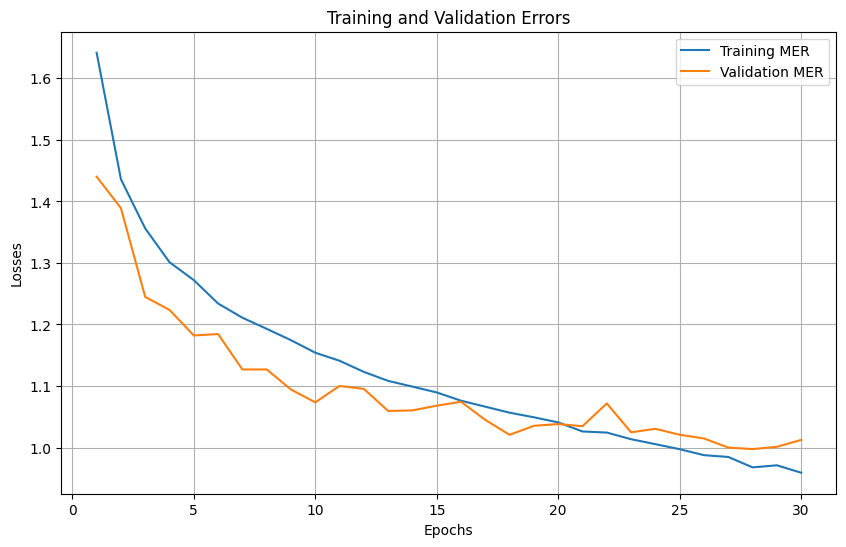

In [65]:
# @title Training Model
model = model_emotioncnn2
n_epochs = 30
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Define parameters and call the function
trained_model, train_errors, valid_errors  = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    train_on_gpu=torch.cuda.is_available(),
    save_path='model_facial_model_emotioncnn2_LossCEL_OptimSGD_LR01_epoch30.pth'
)
plot_errors(train_errors, valid_errors)


Test Loss: 0.984903

Test Accuracy of angry: 60% (575/958)
Test Accuracy of disgust: 36% (41/111)
Test Accuracy of  fear: 35% (359/1024)
Test Accuracy of happy: 83% (1489/1774)
Test Accuracy of neutral: 61% (759/1233)
Test Accuracy of   sad: 53% (662/1247)
Test Accuracy of surprise: 80% (673/831)

Test Accuracy (Overall): 63% (4558/7178)


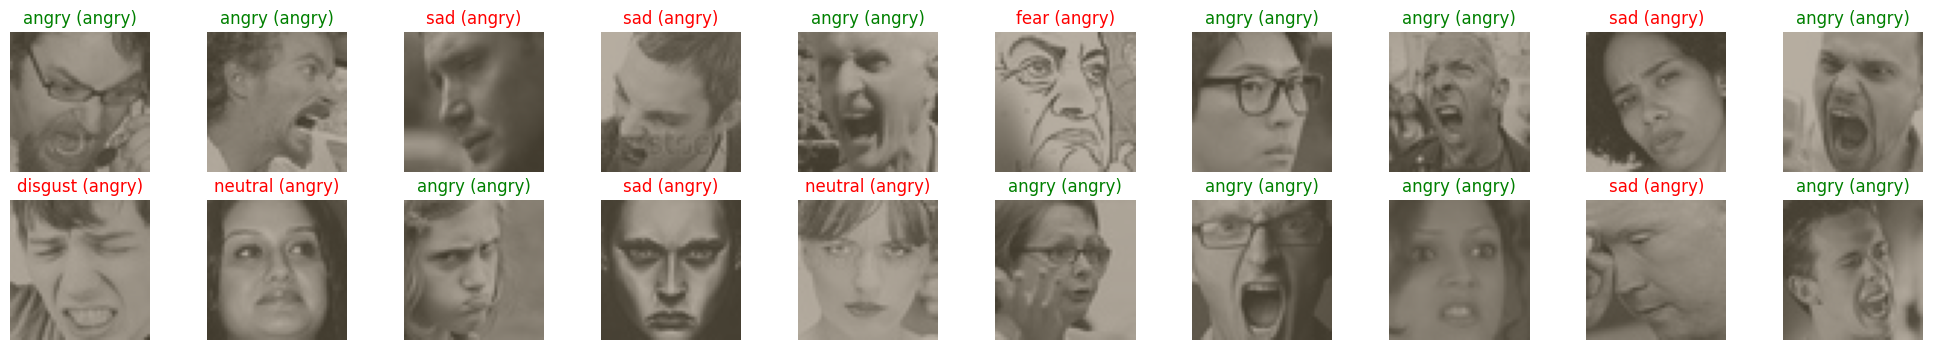

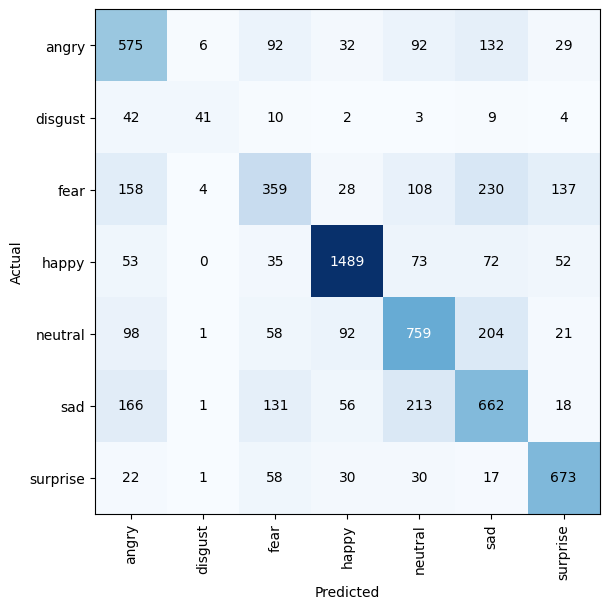

In [66]:
# @title Testing

# Evaluate the model
state_dict = torch.load('/content/model_facial_model_emotioncnn2_LossCEL_OptimSGD_LR01_epoch30.pth', map_location='cpu', weights_only=True)
# state_dict = torch.load('', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    num_classes=7,
    classes=classes,
    test_on_gpu=torch.cuda.is_available()
)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    classes=classes,
    train_on_gpu=torch.cuda.is_available(),
    batch_size=20
)

all_classes = results['true_labels']
predictions = results['predictions']
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)


## VGG16 Model

### VGG-16 Model Description

The **VGG-16** model is a pre-trained deep learning architecture used for image classification tasks. Here’s how it is adapted for our specific emotion recognition problem:

1. **Pretrained Backbone**:
   - The model uses a pre-trained VGG-16 architecture with weights from a large-scale dataset (e.g., ImageNet).
   - The convolutional layers are frozen (`requires_grad=False`) to retain pre-trained feature extraction capabilities.

2. **Modified Classifier**:
   - The fully connected (classifier) layers are modified to suit our classification task:
     - The final layer (`classifier[6]`) is replaced with a fully connected layer mapping 4096 features to 7 output classes.
     - A `LogSoftmax` activation function is applied (`classifier[7]`) to output log-probabilities for each class.

3. **Input and Output**:
   - Input: Standard VGG-16 input size of RGB images (\(224 \times 224 \times 3\)).
   - Output: Log-probabilities for 7 emotion categories.

By leveraging the VGG-16 pre-trained backbone, this setup efficiently adapts to the emotion recognition task while reducing the training time by freezing the convolutional layers.


In [67]:
# @title Defining Model
# VGG Model

model_vgg = models.vgg16(weights='DEFAULT')
# print(model_vgg)

for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 7)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

# print(model_vgg.classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


Epoch: 1 	Training Loss: 4.807711 	Validation Loss: 3.872325
Validation loss decreased (inf --> 3.872325). Saving model ...
Epoch: 2 	Training Loss: 4.871792 	Validation Loss: 3.798713
Validation loss decreased (3.872325 --> 3.798713). Saving model ...
Epoch: 3 	Training Loss: 4.918746 	Validation Loss: 5.038722
Epoch: 4 	Training Loss: 4.877360 	Validation Loss: 4.485803
Epoch: 5 	Training Loss: 4.925504 	Validation Loss: 4.992360
Epoch: 6 	Training Loss: 4.859672 	Validation Loss: 4.312103
Epoch: 7 	Training Loss: 4.938956 	Validation Loss: 3.915315
Epoch: 8 	Training Loss: 4.967658 	Validation Loss: 3.444914
Validation loss decreased (3.798713 --> 3.444914). Saving model ...
Epoch: 9 	Training Loss: 4.900816 	Validation Loss: 6.340245
Epoch: 10 	Training Loss: 4.951947 	Validation Loss: 3.599145
Epoch: 11 	Training Loss: 4.889525 	Validation Loss: 3.728107
Epoch: 12 	Training Loss: 4.872319 	Validation Loss: 5.736660
Epoch: 13 	Training Loss: 4.942150 	Validation Loss: 4.393099
Epoc

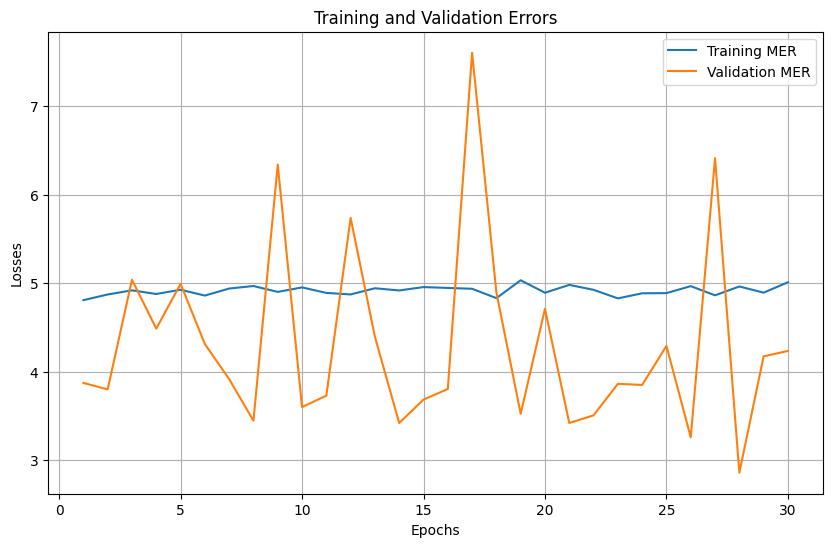

In [68]:
# @title Training Model
model = model_vgg
n_epochs = 30
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Define parameters and call the function
trained_model, train_errors, valid_errors  = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    train_on_gpu=torch.cuda.is_available(),
    save_path='model_facial_model_vgg16_LossCEL_OptimSGD_LR01_epoch30.pth'
)
plot_errors(train_errors, valid_errors)


Test Loss: 3.322996

Test Accuracy of angry: 32% (308/958)
Test Accuracy of disgust: 15% (17/111)
Test Accuracy of  fear:  6% (67/1024)
Test Accuracy of happy: 51% (922/1774)
Test Accuracy of neutral: 16% (205/1233)
Test Accuracy of   sad: 12% (157/1247)
Test Accuracy of surprise: 68% (572/831)

Test Accuracy (Overall): 31% (2248/7178)


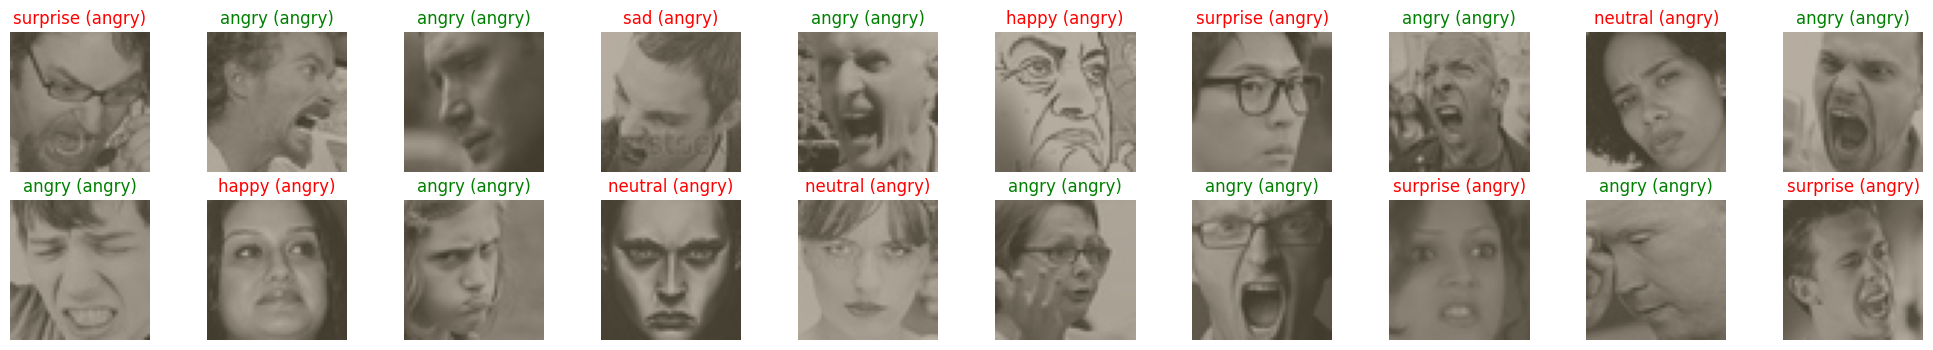

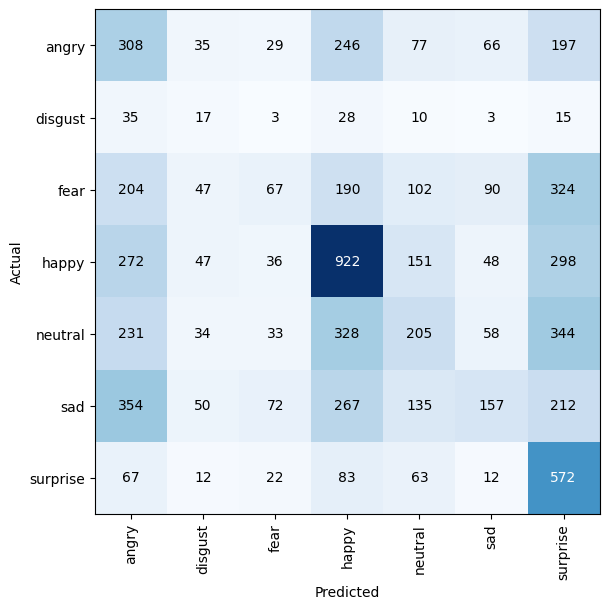

In [69]:
# @title Testing

# Evaluate the model
state_dict = torch.load('/content/model_facial_model_vgg16_LossCEL_OptimSGD_LR01_epoch30.pth', map_location='cpu', weights_only=True)
# state_dict = torch.load('', map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    num_classes=7,
    classes=classes,
    test_on_gpu=torch.cuda.is_available()
)

visualize_predictions(
    model=model,
    test_loader=test_loader,
    classes=classes,
    train_on_gpu=torch.cuda.is_available(),
    batch_size=20
)

all_classes = results['true_labels']
predictions = results['predictions']
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)



# ViT Model Loading

### Vision Transformer (ViT) Model Description

The **Vision Transformer (ViT)** model is a cutting-edge deep learning architecture adapted for emotion recognition tasks. Below are the key details of the setup:

1. **Model Architecture**:
   - Uses the **ViT Base** model with a patch size of 16 (\(`vit_base_patch16_224`\)), which divides input images into \(16 \times 16\) patches.
   - Each patch is embedded and processed using transformer-based attention mechanisms instead of convolutional layers, enabling the model to capture global image relationships.

2. **Customization**:
   - The default classification head is replaced with a fully connected layer to output predictions for the number of emotion categories (`len(classes)`).

3. **Pretrained Weights and Fine-Tuning**:
   - Pretrained weights are not used in this setup, as the model is trained from scratch.
   - The model is loaded with pre-trained parameters (`trained_vit_model.pth`) for emotion classification, ensuring the head matches the dataset's class structure.

4. **Device Compatibility**:
   - The model is configured to utilize GPU (`model.cuda()`) for faster training and inference if available (`train_on_gpu` is `True`).

This ViT implementation highlights the model’s ability to leverage transformer-based architectures for image classification tasks, offering state-of-the-art performance in emotion recognition.


In [30]:

# Load the trained model
model_path = "trained_vit_model.pth"
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, len(classes))  # Ensure output matches the number of classes
model.load_state_dict(torch.load(model_path))
# model = model.to(device)
if train_on_gpu:
      model.cuda()

<ipython-input-30-d4b95c671f05>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



# New Image Process and Emotion Detection

In [52]:
# @title Function for New Image Process and Emotion Detection
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.gridspec as gridspec

def imshow(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    img = tensor.permute(1, 2, 0).numpy()
    img = np.clip(img * std + mean, 0, 1)
    plt.imshow(img)
    plt.axis('off')

def predict_and_plot(model, size, image_path, classes, style='basic'):
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    resized_image = transform(image)

    # Run Model Inference
    input_tensor = resized_image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_label = classes[predicted_class.item()]

    # Get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy().flatten()

    # Prepare figure based on style
    if style == 'basic':
        # Basic style: 3 subplots in a row, equal space
        # --- Display the Original and Resized Image ---
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original")
        plt.axis('off')

        # Resized image
        plt.subplot(1, 2, 2)
        imshow(resized_image)  # Using imshow function to display resized tensor
        plt.title("Resized (3x"+str(size)+"x"+str(size)+")")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # --- Plot Probabilities as a Horizontal Bar Chart ---
        plt.figure(figsize=(6, 4))
        plt.barh(classes, probabilities, color='skyblue')
        plt.xlabel("Probability")
        plt.title("Emotion Recognition Probabilities")
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.gca().invert_yaxis()  # Optional: put highest probability on top
        plt.tight_layout()
        plt.show()

    elif style == 'gridspec':
        # Gridspec style: allocate more space to the third subplot
        fig = plt.figure(figsize=(10, 3))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])

        # Original image
        ax1 = fig.add_subplot(gs[0])
        ax1.imshow(image)
        ax1.set_title("Original")
        ax1.axis('off')

        # Resized image
        ax2 = fig.add_subplot(gs[1])
        imshow(resized_image)
        ax2.set_title("Resized (3x"+str(size)+"x"+str(size)+")")
        ax2.axis('off')

        # Probability Bar Chart
        ax3 = fig.add_subplot(gs[2])
        ax3.barh(classes, probabilities, color='skyblue')
        ax3.set_xlabel("Probability")
        ax3.set_title("Emotion Recognition Probabilities")
        ax3.grid(axis='x', linestyle='--', alpha=0.7)
        ax3.invert_yaxis()

        plt.tight_layout()
        plt.show()

    print(f"Predicted Expression: {predicted_label}")
    return predicted_label


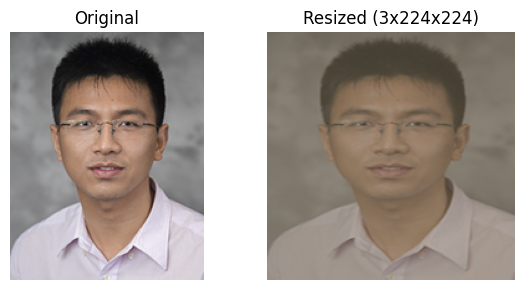

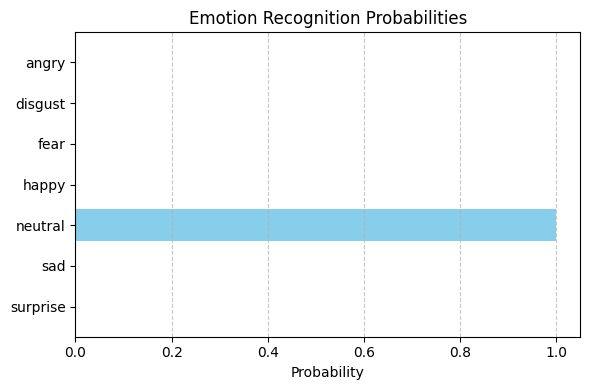

Predicted Expression: neutral


In [53]:
predicted = predict_and_plot(model,224, "/content/drive/MyDrive/03_Duke_University/29_Term_3_Modern_Analytics/Final_Project/Photos/fs_jx77.jpg", classes, style='basic')

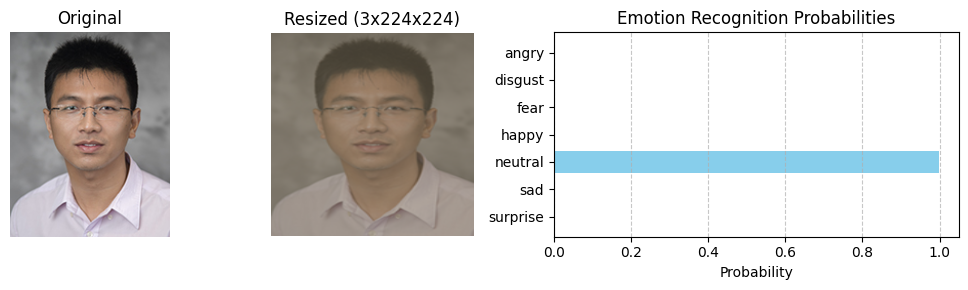

Predicted Expression: neutral


In [54]:
predicted = predict_and_plot(model,224, "/content/drive/MyDrive/03_Duke_University/29_Term_3_Modern_Analytics/Final_Project/Photos/fs_jx77.jpg", classes, style='gridspec')

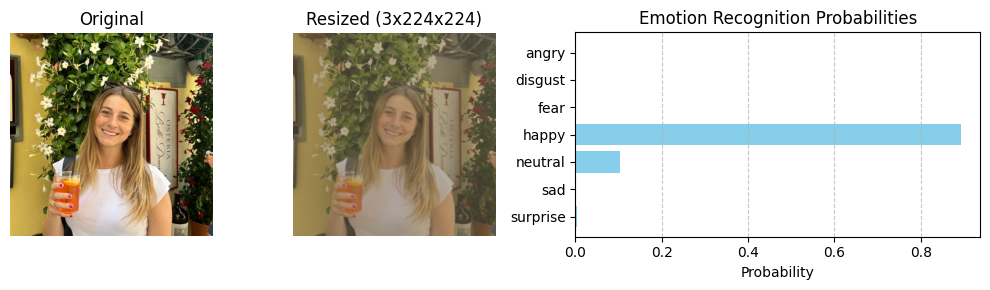

Predicted Expression: happy


In [55]:
predicted = predict_and_plot(model,224, "/content/drive/MyDrive/03_Duke_University/29_Term_3_Modern_Analytics/Final_Project/Photos/Caterina.jpg", classes, style='gridspec')

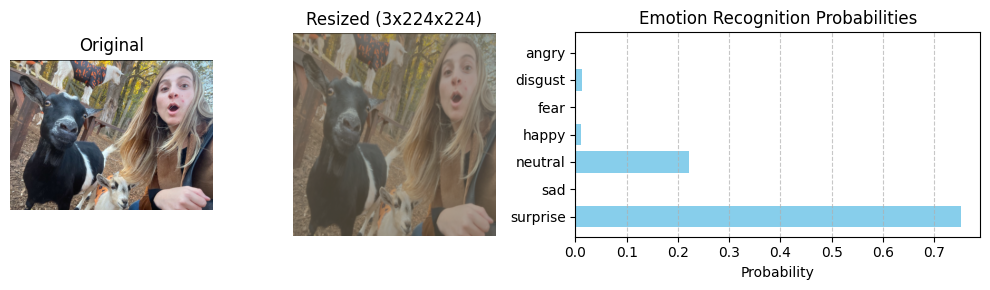

Predicted Expression: surprise


In [44]:
predicted = predict_and_plot(model, 224,"/content/drive/MyDrive/03_Duke_University/29_Term_3_Modern_Analytics/Final_Project/Photos/WhatsApp Image 2024-12-07 at 15.09.13_c8d22473.jpg", classes, style='gridspec')